In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import h5py
import pandas as pd
import scipy

from sklearn.decomposition import PCA

# Dimension reduction and clustering libraries
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [38]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [39]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

In [50]:
import plotly.graph_objects as go
from mycolorpy import colorlist as mcp

def alluvial_plot(cluster_labels, id_clustering, colormap = "Paired"):
    
  size_clustering1 = np.max(cluster_labels[0])
  size_clustering2 = np.max(cluster_labels[1])

  palette =mcp.gen_color(cmap=colormap,n= size_clustering1 + size_clustering2 + 1)


  names = ['none'] + [id_clustering[0] + str(k) for k in range(1,size_clustering1 +1)]
  names2 = [id_clustering[1] + str(k) for k in range(1,size_clustering2 +1)] 
  fig = go.Figure(data=[go.Sankey(
      node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = np.hstack([names, names2]), #cell labels
        color = [palette[val] for val in [ k for k in range(size_clustering1+1)] + [k for k in range(size_clustering1+1,size_clustering1 +size_clustering2+1)] ]#color (cluster label + palette )
      ),
      link = dict(
        source = cluster_labels[0], # 
        target = [k + size_clustering1 for k in cluster_labels[1]],
        value = [1 for _ in range(cluster_labels[0].shape[0])],
        color =[palette[val] for val in cluster_labels[0]] #np.array(["blue",'red','green','yellow'])
    ))])

  #fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
  fig.show()

#alluvial_plot(cluster_labels, id_clustering = ['cluster','truc'])

# VAF clustering

In [41]:
vaf_filter = vafs.copy()
vaf_filter = vaf_filter[variants.id[variants.filtered == 0].values]
vaf_filter = vaf_filter.loc[cell_filters.barcode[cell_filters.filtered == 0].values]
thresh = 0.05
binary_vafs = vaf_filter.applymap(lambda x : 1 if x > thresh else 0)
vaf_filter

,b'chr1:115256513:G/A',b'chr1:115256669:G/A',b'chr2:25458546:C/T',b'chr2:25470573:G/A',b'chr2:25471169:GC/G',b'chr2:25471170:C/*',b'chr3:128200690:G/A',b'chr3:128200806:G/A',b'chr4:55599429:C/T',b'chr4:55599436:T/C',...,b'chr17:7577581:A/G',b'chr17:7578115:T/C',b'chr17:7578211:C/T',b'chr17:7578263:G/A',b'chr17:7578523:T/TG',b'chr17:7580052:C/T',b'chr20:31022288:C/A',b'chr20:31023356:G/T',b'chr21:36252917:C/T',b'chr21:44514777:T/C'
b'AACAACCTACAGAAGTGA-1',0.111111,0.970588,0.000000,0.000000,0.000000,0.000000,0.062500,0.03125,0.350000,0.650000,...,0.000000,1.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541667
b'AACAACCTATCTATGACA-1',0.222222,1.000000,0.545455,0.352941,0.000000,0.000000,0.000000,0.00000,0.000000,0.500000,...,0.000000,1.00,0.0,0.857143,0.000000,0.000000,0.000000,0.617021,0.587302,0.000000
b'AACAACTGGCAACGCACA-1',0.023256,1.000000,0.000000,0.000000,0.348837,0.348837,0.028571,0.00000,0.414634,0.560976,...,0.000000,1.00,0.0,0.000000,0.000000,0.000000,0.000000,0.015873,0.000000,0.531250
b'AACACACTCTTACAGTGT-1',0.019608,0.658537,0.069767,0.000000,0.000000,0.029412,0.161290,1.00000,0.000000,0.594595,...,0.387097,0.75,0.2,0.000000,0.588235,0.428571,0.217391,0.000000,0.021739,0.018868
b'AACAGCAGTCGTCTGCTG-1',0.000000,1.000000,0.326531,0.235294,0.000000,0.000000,0.000000,0.00000,0.000000,0.384615,...,0.000000,1.00,0.0,0.476190,0.062500,0.000000,0.000000,0.538462,0.490196,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0.000000,1.000000,0.625000,0.555556,0.000000,0.031250,0.000000,0.00000,0.000000,0.461538,...,0.000000,1.00,0.0,0.142857,0.000000,0.000000,0.000000,0.450000,0.307692,0.000000
b'TTGGAGAACTGAACTTGC-1',0.000000,0.384615,0.382979,0.000000,0.000000,0.073171,0.000000,1.00000,0.000000,1.000000,...,0.000000,1.00,0.0,0.000000,1.000000,1.000000,0.145833,0.000000,0.000000,0.000000
b'TTGGTAACTTCTGCGCTG-1',0.021739,0.690476,0.176471,0.000000,0.000000,0.037736,0.026316,1.00000,0.000000,0.973684,...,0.000000,1.00,0.0,0.000000,1.000000,1.000000,0.133333,0.000000,0.018519,0.000000
b'TTGTCAACCGCAGCAGTG-1',0.000000,0.437500,0.159091,0.000000,0.000000,0.039216,0.000000,0.96000,0.000000,1.000000,...,0.000000,1.00,0.0,0.000000,1.000000,1.000000,0.393939,0.000000,0.000000,0.000000


<Axes: >

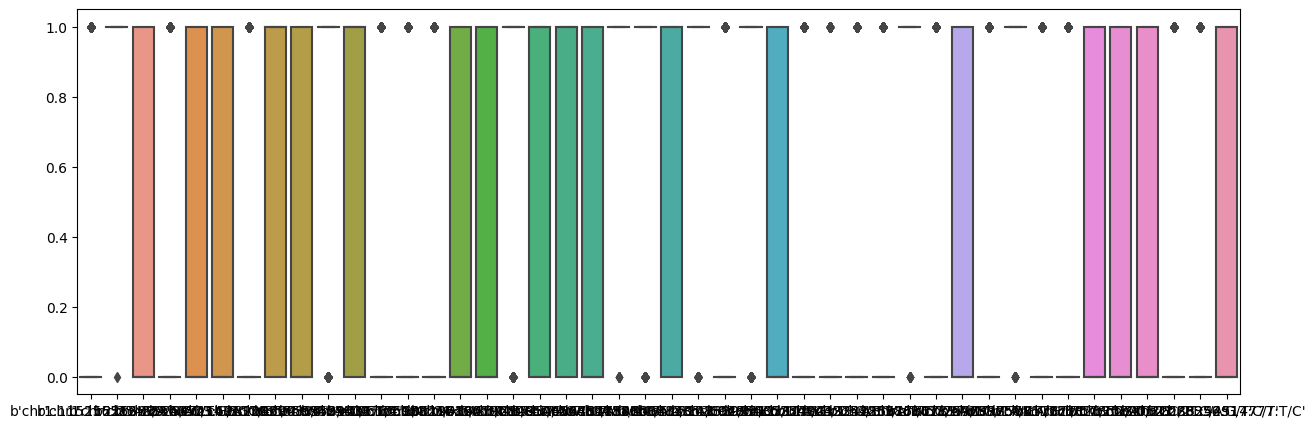

In [42]:
plt.figure(figsize=(15,5))

sns.boxplot(binary_vafs) # mean 1 == truncal mutation

<Axes: >

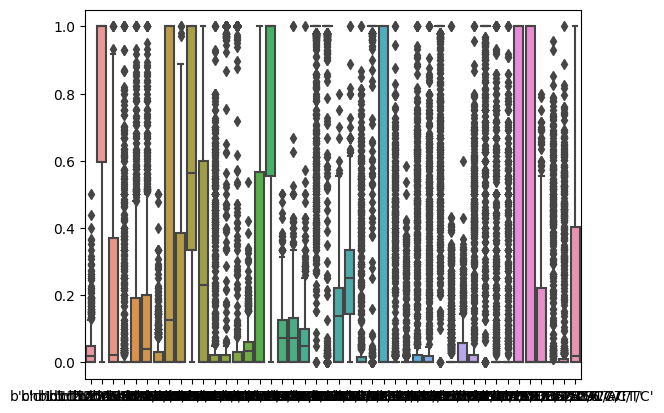

In [21]:
sns.boxplot(vaf_filter)

<Axes: ylabel='Count'>

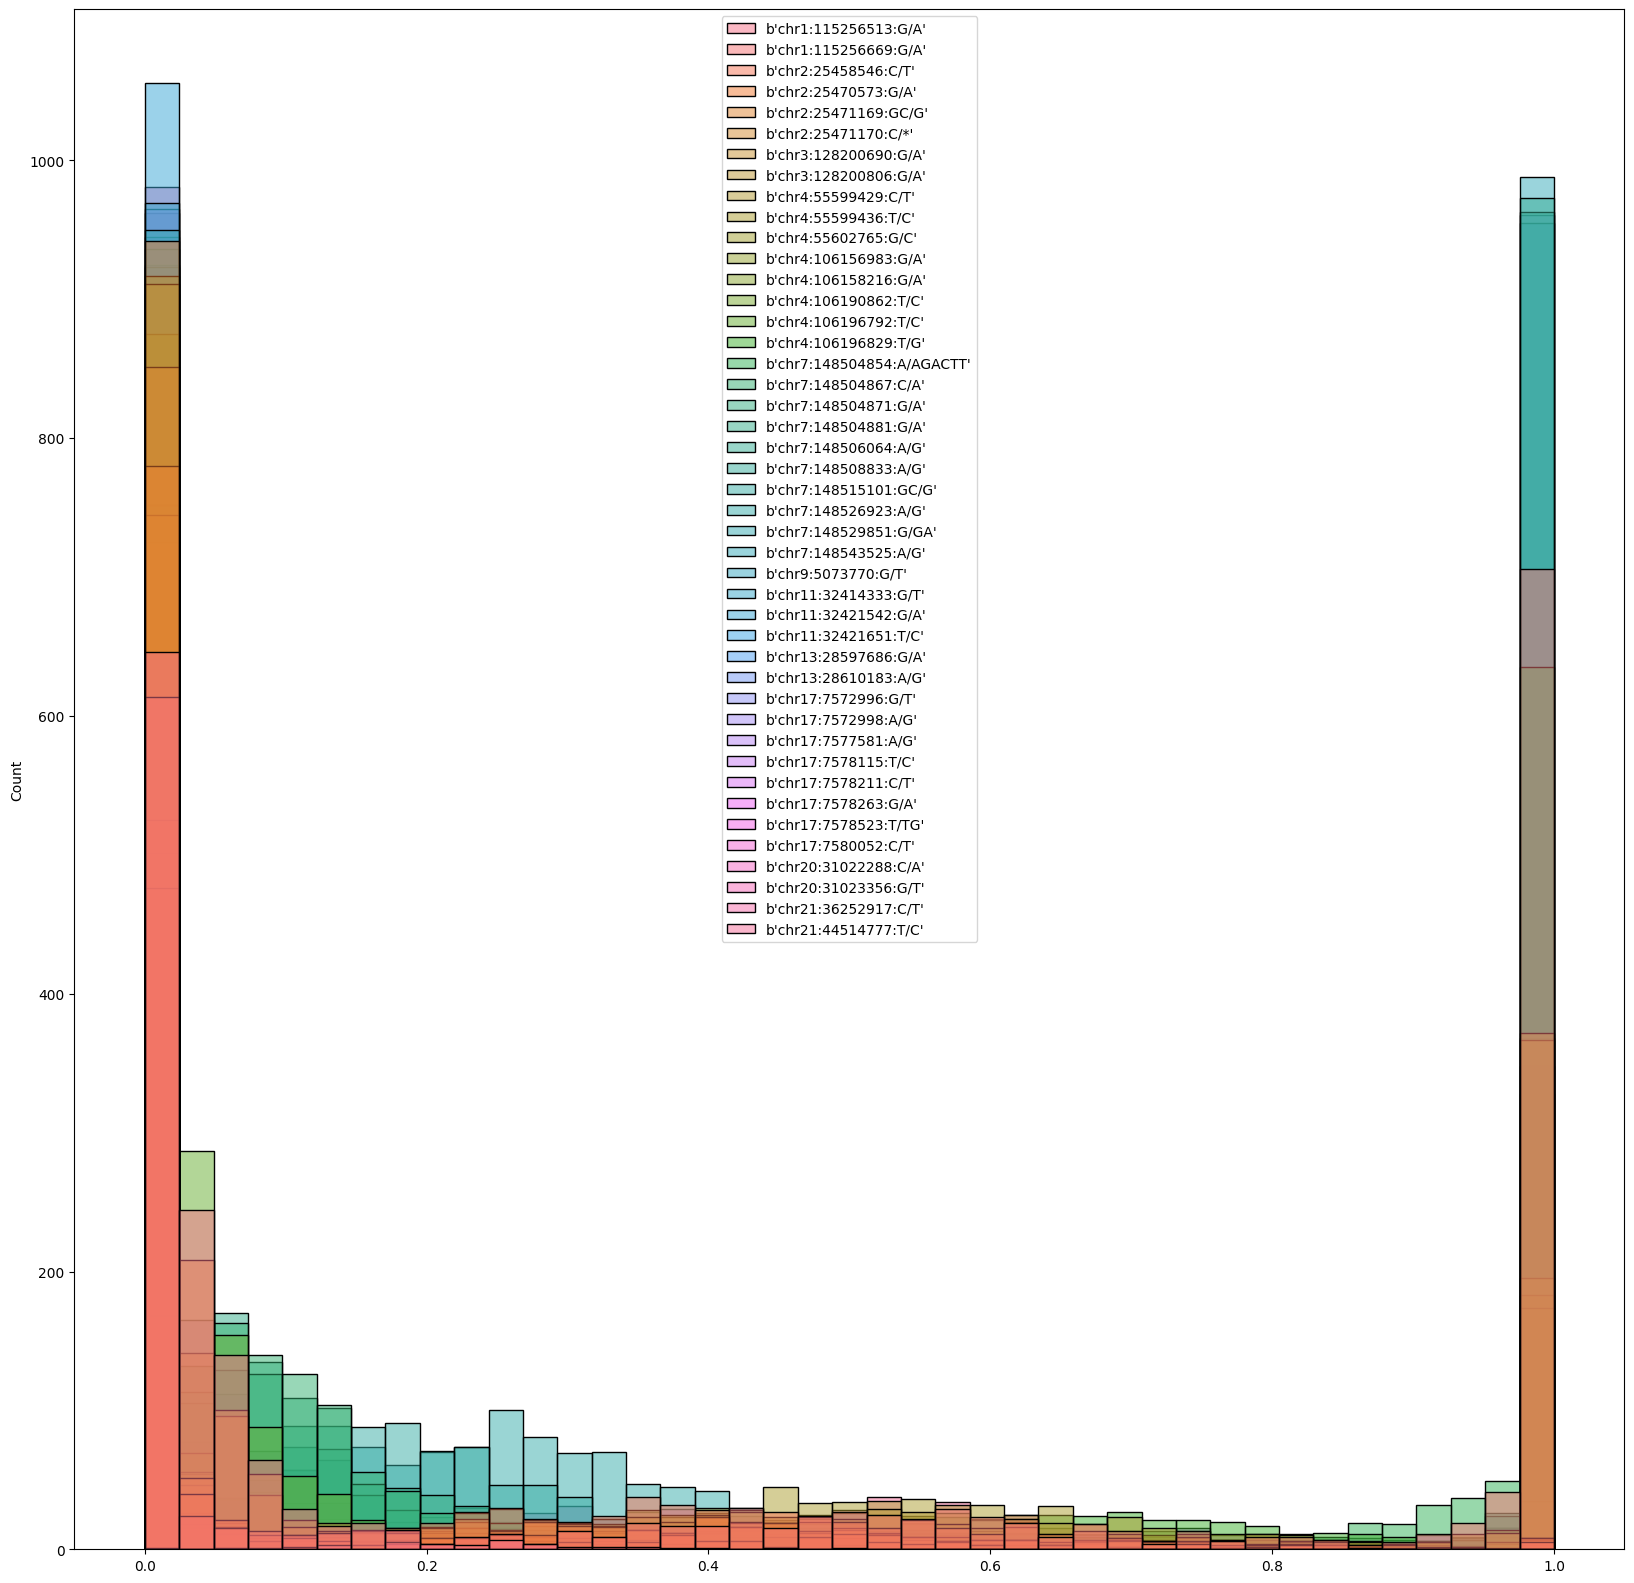

In [44]:
plt.figure(figsize=(20,20))

sns.histplot(vaf_filter)

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



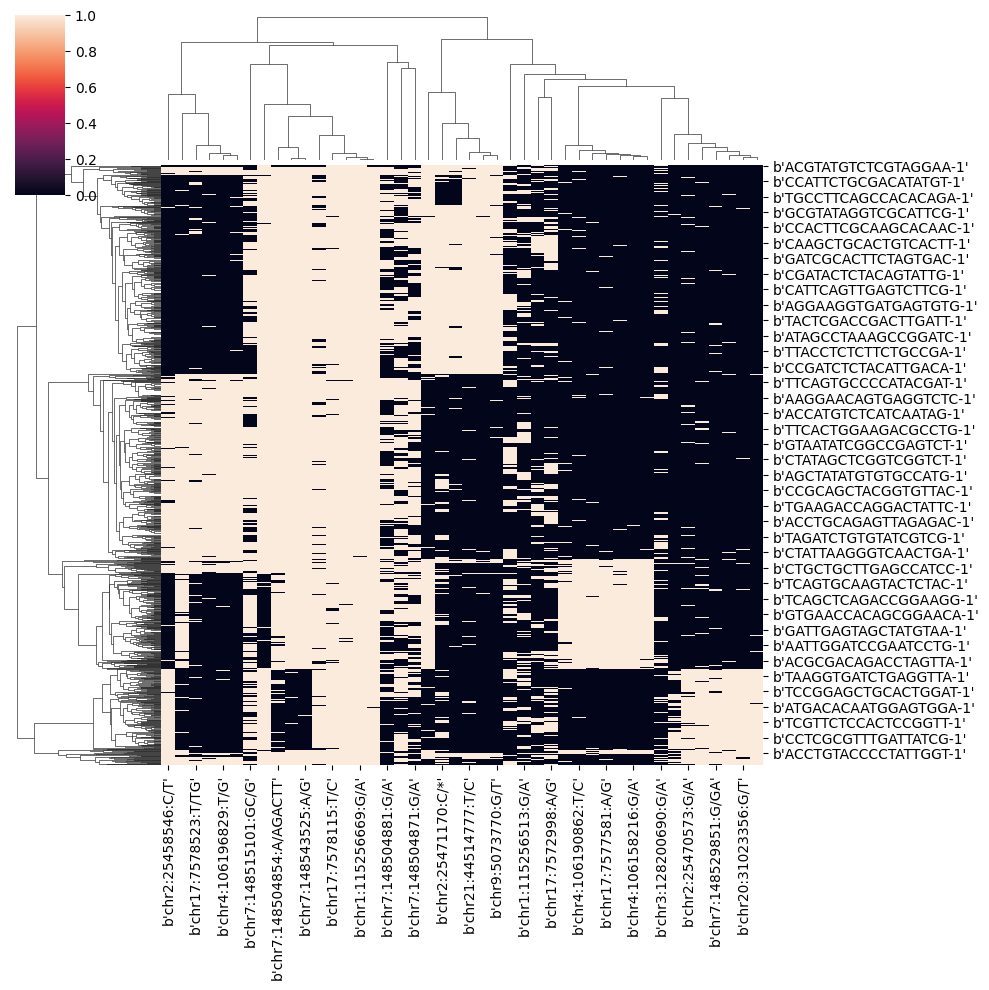

In [45]:
sns.clustermap(binary_vafs, method='weighted', metric = 'hamming')

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



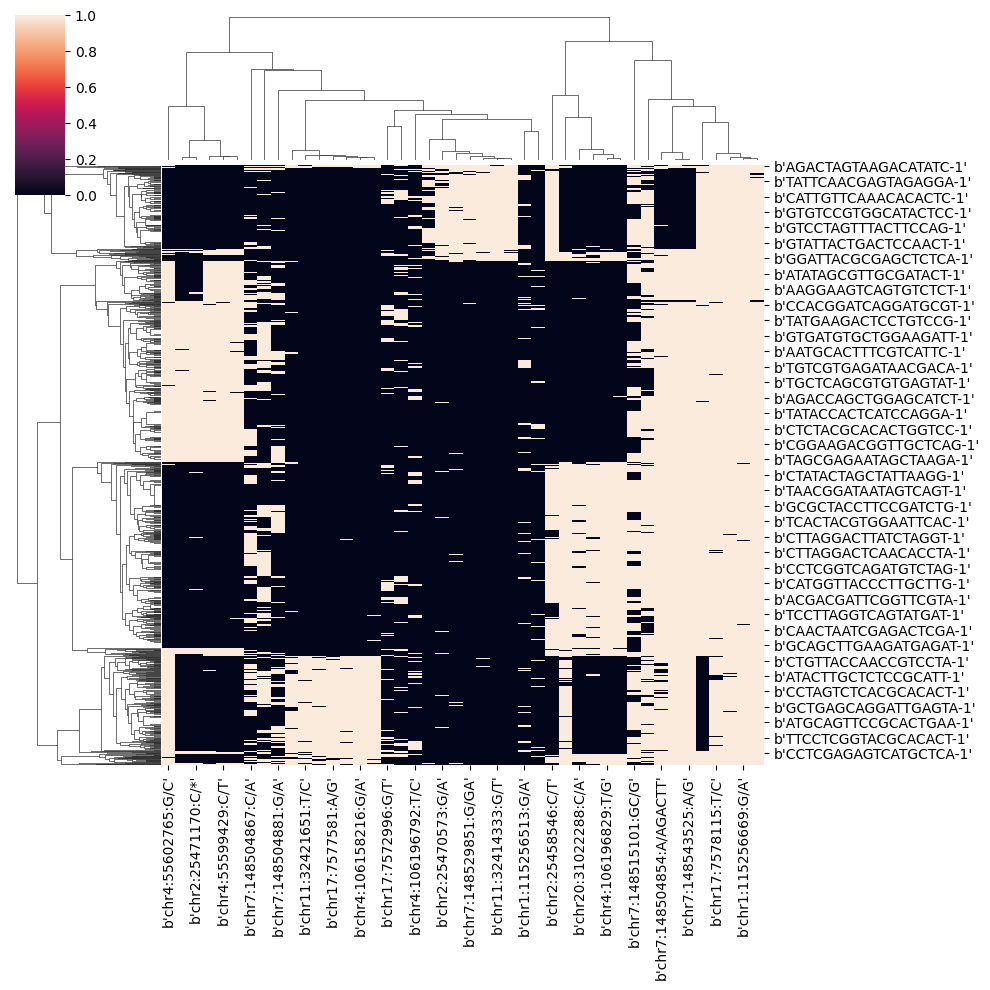

In [46]:
thresh = 0.1
binary_vafs = vaf_filter.applymap(lambda x : 1 if x > thresh else 0)
sns.clustermap(binary_vafs, method='weighted', metric = 'hamming')

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
thresh = [0.05, 0.1]
cluster_labels = []

for t in thresh:
    binary_vafs = vaf_filter.applymap(lambda x : 1 if x > t else 0)
    linkage_data = linkage(binary_vafs.to_numpy(), method='weighted', metric='hamming')

    cluster_labels.append(fcluster(linkage_data,t = 0.35, criterion='distance')) #ward cluster (colors)
#cluster_labels = cluster_labels[ward_cluster.dendrogram_row.reordered_ind] #ward cluster (reordering, position)

#my_palette = plt.cm.get_cmap("Accent", 5)
#np.unique(cluster_labels), cluster_labels

In [51]:
alluvial_plot(cluster_labels, id_clustering=["cluster_thresh_05_","cluster_thresh_1_" ])

In [103]:

import plotly.graph_objects as go
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

#  np.hstack([binary_vafs.index.values.astype(str), binary_vafs.index.values.astype(str)])
names = binary_vafs.index.values.astype(str)
names2 = [n + "_2" for n in binary_vafs.index.values.astype(str)]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = np.hstack([names, names2]), #cell labels
      color = [ DEFAULT_PLOTLY_COLORS[lab] for lab in np.hstack(cluster_labels)] #color (cluster label + palette )
    ),
    link = dict(
      source = [k for k in range(1201)], # 
      target = [1201 + k for k in range(1201)],
      value = [1 for _ in range(binary_vafs.index.values.astype(str).shape[0])],
      color = [ DEFAULT_PLOTLY_COLORS[lab] for lab in cluster_labels[0]]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

#my_palette = plt.cm.get_cmap("Accent", 5)
#val=cluster_labels[num]
#my_palette(val)

In [13]:
import plotly.graph_objects as go
DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

names = ['none','clust1','clust2', 'clust3']
names2 = ["2" + n for n in names[1:]]
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = np.hstack([names, names2]), #cell labels
      color = [DEFAULT_PLOTLY_COLORS[val] for val in [0,1,2,3]+[4,5,6]] #color (cluster label + palette )
    ),
    link = dict(
      source = [1,1,2,2,3,3], # 
      target = [k + 3 for k in [2,2,1,1,3,3]],
      value = [1 for _ in range(6)],
      color =[DEFAULT_PLOTLY_COLORS[val] for val in [1,1,2,2,3,3]] #np.array(["blue",'red','green','yellow'])
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

#my_palette = plt.cm.get_cmap("Accent", 5)
#val=cluster_labels[num]
#my_palette(val)

In [4]:
variants_read_counts = (vafs*covs)[variants.id[variants.filtered == 0].values]
variants_read_counts = variants_read_counts.loc[cell_filters.barcode[cell_filters.filtered == 0].values]
variants_read_counts

,b'chr1:115256513:G/A',b'chr1:115256669:G/A',b'chr2:25458546:C/T',b'chr2:25470573:G/A',b'chr2:25471169:GC/G',b'chr2:25471170:C/*',b'chr3:128200690:G/A',b'chr3:128200806:G/A',b'chr4:55599429:C/T',b'chr4:55599436:T/C',...,b'chr17:7577581:A/G',b'chr17:7578115:T/C',b'chr17:7578211:C/T',b'chr17:7578263:G/A',b'chr17:7578523:T/TG',b'chr17:7580052:C/T',b'chr20:31022288:C/A',b'chr20:31023356:G/T',b'chr21:36252917:C/T',b'chr21:44514777:T/C'
b'AACAACCTACAGAAGTGA-1',4.0,33.0,0.0,0.0,0.0,0.0,2.0,1.0,14.0,26.0,...,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
b'AACAACCTATCTATGACA-1',2.0,11.0,12.0,6.0,0.0,0.0,0.0,0.0,0.0,12.0,...,0.0,9.0,0.0,6.0,0.0,0.0,0.0,29.0,37.0,0.0
b'AACAACTGGCAACGCACA-1',1.0,43.0,0.0,0.0,15.0,15.0,1.0,0.0,17.0,23.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.0
b'AACACACTCTTACAGTGT-1',1.0,27.0,3.0,0.0,0.0,1.0,5.0,30.0,0.0,22.0,...,12.0,3.0,1.0,0.0,10.0,21.0,5.0,0.0,2.0,1.0
b'AACAGCAGTCGTCTGCTG-1',0.0,30.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,10.0,...,0.0,22.0,0.0,10.0,1.0,0.0,0.0,35.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0.0,9.0,10.0,5.0,0.0,1.0,0.0,0.0,0.0,6.0,...,0.0,15.0,0.0,2.0,0.0,0.0,0.0,9.0,8.0,0.0
b'TTGGAGAACTGAACTTGC-1',0.0,20.0,18.0,0.0,0.0,3.0,0.0,16.0,0.0,46.0,...,0.0,20.0,0.0,0.0,33.0,50.0,7.0,0.0,0.0,0.0
b'TTGGTAACTTCTGCGCTG-1',1.0,29.0,9.0,0.0,0.0,2.0,1.0,35.0,0.0,37.0,...,0.0,12.0,0.0,0.0,27.0,50.0,6.0,0.0,2.0,0.0
b'TTGTCAACCGCAGCAGTG-1',0.0,21.0,7.0,0.0,0.0,2.0,0.0,24.0,0.0,38.0,...,0.0,11.0,0.0,0.0,9.0,27.0,13.0,0.0,0.0,0.0


/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


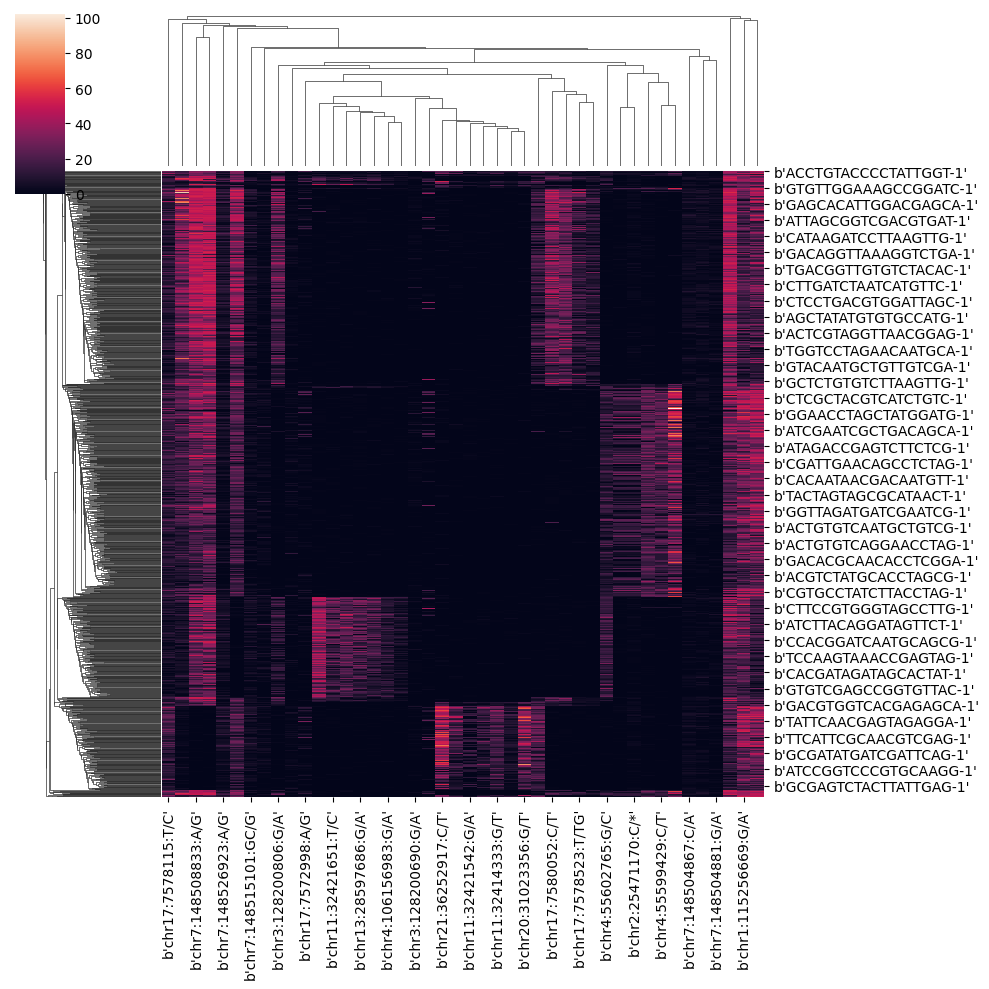

In [5]:
sns.clustermap(variants_read_counts, metric='hamming')

<Axes: >

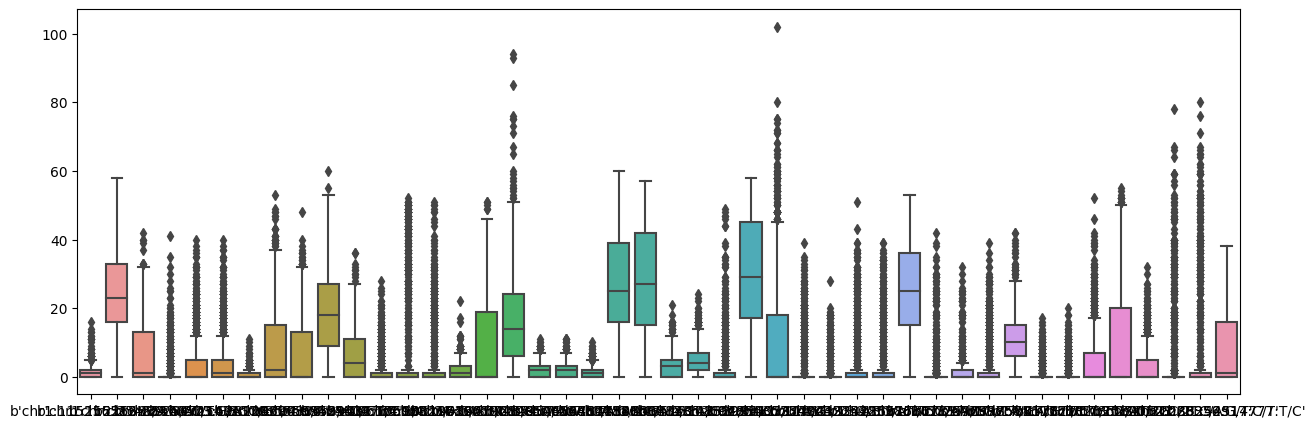

In [6]:
plt.figure(figsize=(15,5))

sns.boxplot(variants_read_counts)

In [37]:
thresh = 10
mutation_matrix = variants_read_counts.applymap(lambda x : 1 if x > thresh else 0)
mutation_matrix

,b'chr1:115256513:G/A',b'chr1:115256669:G/A',b'chr2:25458546:C/T',b'chr2:25470573:G/A',b'chr2:25471169:GC/G',b'chr2:25471170:C/*',b'chr3:128200690:G/A',b'chr3:128200806:G/A',b'chr4:55599429:C/T',b'chr4:55599436:T/C',...,b'chr17:7577581:A/G',b'chr17:7578115:T/C',b'chr17:7578211:C/T',b'chr17:7578263:G/A',b'chr17:7578523:T/TG',b'chr17:7580052:C/T',b'chr20:31022288:C/A',b'chr20:31023356:G/T',b'chr21:36252917:C/T',b'chr21:44514777:T/C'
b'AACAACCTACAGAAGTGA-1',0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
b'AACAACCTATCTATGACA-1',0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
b'AACAACTGGCAACGCACA-1',0,1,0,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
b'AACACACTCTTACAGTGT-1',0,1,0,0,0,0,0,1,0,1,...,1,0,0,0,0,1,0,0,0,0
b'AACAGCAGTCGTCTGCTG-1',0,1,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
b'TTGGAGAACTGAACTTGC-1',0,1,1,0,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,0,0
b'TTGGTAACTTCTGCGCTG-1',0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,1,1,0,0,0,0
b'TTGTCAACCGCAGCAGTG-1',0,1,0,0,0,0,0,1,0,1,...,0,1,0,0,0,1,1,0,0,0


/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



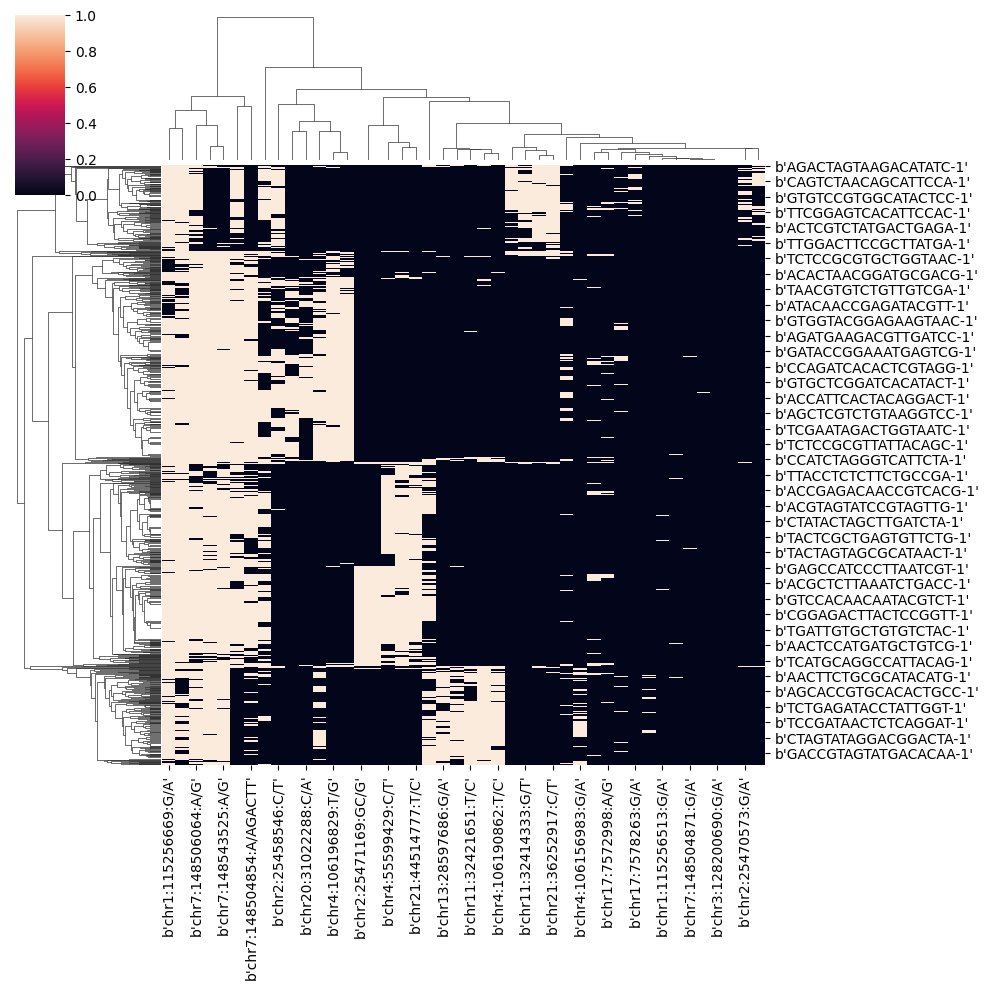

In [38]:
sns.clustermap(mutation_matrix, metric='hamming')

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



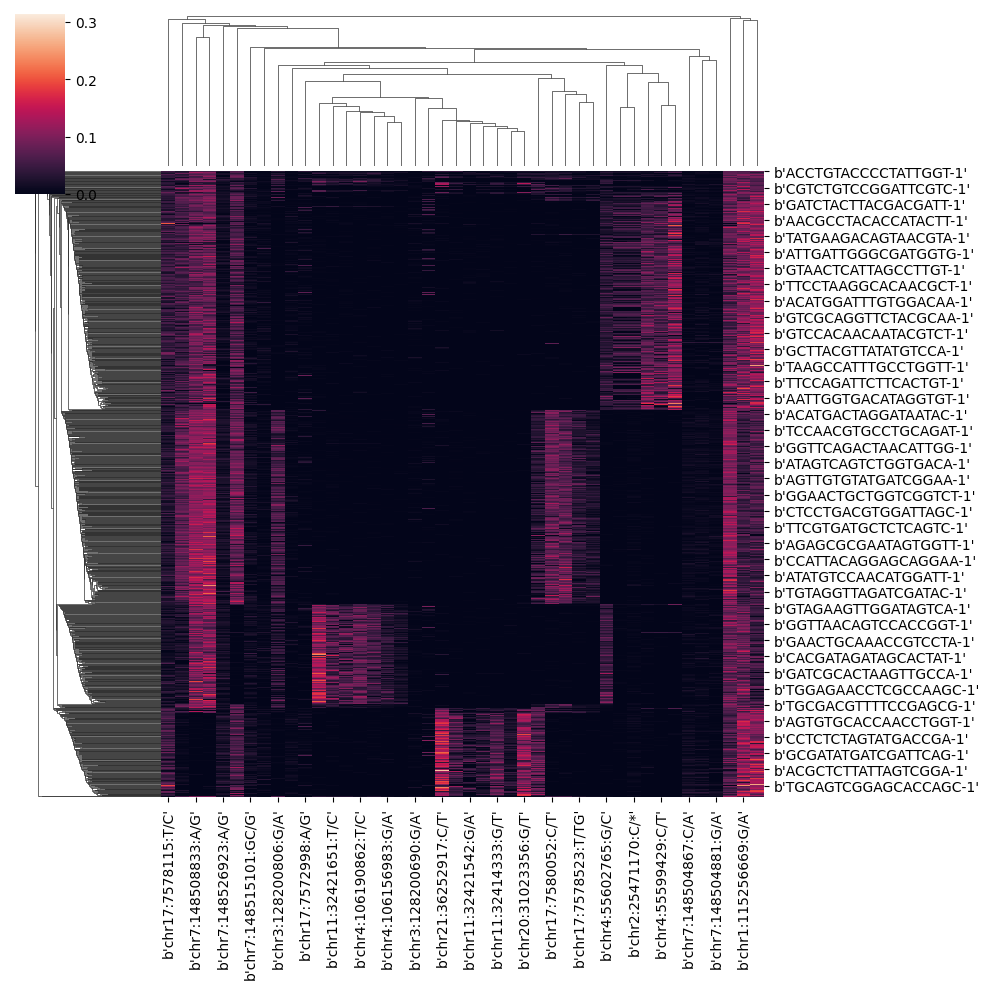

In [22]:
sns.clustermap(variants_read_counts.apply(lambda x : x/variants_read_counts.sum(axis=1), axis=0), metric='hamming')

In [23]:
vaf_filter = vafs.copy()
vaf_filter = vaf_filter[variants.id[variants.filtered == 0].values]
vaf_filter = vaf_filter.loc[cell_filters.barcode[cell_filters.filtered == 0].values]
vaf_filter

,b'chr1:115256513:G/A',b'chr1:115256669:G/A',b'chr2:25458546:C/T',b'chr2:25470573:G/A',b'chr2:25471169:GC/G',b'chr2:25471170:C/*',b'chr3:128200690:G/A',b'chr3:128200806:G/A',b'chr4:55599429:C/T',b'chr4:55599436:T/C',...,b'chr17:7577581:A/G',b'chr17:7578115:T/C',b'chr17:7578211:C/T',b'chr17:7578263:G/A',b'chr17:7578523:T/TG',b'chr17:7580052:C/T',b'chr20:31022288:C/A',b'chr20:31023356:G/T',b'chr21:36252917:C/T',b'chr21:44514777:T/C'
b'AACAACCTACAGAAGTGA-1',0.111111,0.970588,0.000000,0.000000,0.000000,0.000000,0.062500,0.03125,0.350000,0.650000,...,0.000000,1.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.541667
b'AACAACCTATCTATGACA-1',0.222222,1.000000,0.545455,0.352941,0.000000,0.000000,0.000000,0.00000,0.000000,0.500000,...,0.000000,1.00,0.0,0.857143,0.000000,0.000000,0.000000,0.617021,0.587302,0.000000
b'AACAACTGGCAACGCACA-1',0.023256,1.000000,0.000000,0.000000,0.348837,0.348837,0.028571,0.00000,0.414634,0.560976,...,0.000000,1.00,0.0,0.000000,0.000000,0.000000,0.000000,0.015873,0.000000,0.531250
b'AACACACTCTTACAGTGT-1',0.019608,0.658537,0.069767,0.000000,0.000000,0.029412,0.161290,1.00000,0.000000,0.594595,...,0.387097,0.75,0.2,0.000000,0.588235,0.428571,0.217391,0.000000,0.021739,0.018868
b'AACAGCAGTCGTCTGCTG-1',0.000000,1.000000,0.326531,0.235294,0.000000,0.000000,0.000000,0.00000,0.000000,0.384615,...,0.000000,1.00,0.0,0.476190,0.062500,0.000000,0.000000,0.538462,0.490196,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',0.000000,1.000000,0.625000,0.555556,0.000000,0.031250,0.000000,0.00000,0.000000,0.461538,...,0.000000,1.00,0.0,0.142857,0.000000,0.000000,0.000000,0.450000,0.307692,0.000000
b'TTGGAGAACTGAACTTGC-1',0.000000,0.384615,0.382979,0.000000,0.000000,0.073171,0.000000,1.00000,0.000000,1.000000,...,0.000000,1.00,0.0,0.000000,1.000000,1.000000,0.145833,0.000000,0.000000,0.000000
b'TTGGTAACTTCTGCGCTG-1',0.021739,0.690476,0.176471,0.000000,0.000000,0.037736,0.026316,1.00000,0.000000,0.973684,...,0.000000,1.00,0.0,0.000000,1.000000,1.000000,0.133333,0.000000,0.018519,0.000000
b'TTGTCAACCGCAGCAGTG-1',0.000000,0.437500,0.159091,0.000000,0.000000,0.039216,0.000000,0.96000,0.000000,1.000000,...,0.000000,1.00,0.0,0.000000,1.000000,1.000000,0.393939,0.000000,0.000000,0.000000


/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



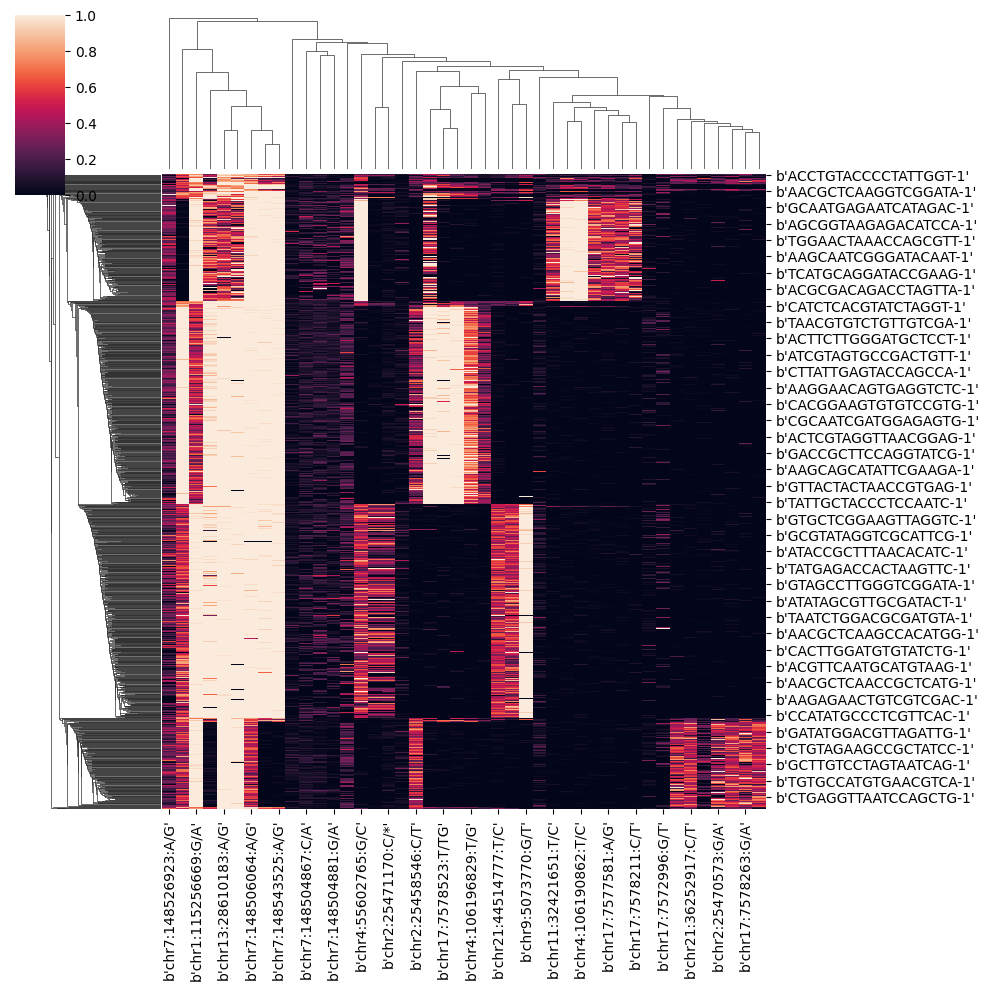

In [24]:
sns.clustermap(vaf_filter, metric='hamming')